In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mltools import my_convert_to_number, my_convert_to_date
from wordcloud import WordCloud
from collections import Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold

#pd.set_option("display.max_rows", None, "display.max_columns", None)
sns.set(style="darkgrid")

## Load ODI

In [2]:
odi_df = pd.read_csv('ODI-2022.csv',delimiter=";")
sns.__version__

'0.11.2'

### Number of records

In [3]:
print(len(odi_df.index))

304


### Number of attributes

In [4]:
print(len(odi_df.columns))

17


### Attributes
    

In [5]:
print((odi_df.columns))

Index(['Tijdstempel', 'What programme are you in?',
       'Have you taken a course on machine learning?',
       'Have you taken a course on information retrieval?',
       'Have you taken a course on statistics?',
       'Have you taken a course on databases?', 'What is your gender?',
       'Chocolate makes you.....', 'When is your birthday (date)?',
       'Number of neighbors sitting around you?', 'Did you stand up?',
       'What is your stress level (0-100)?',
       'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ',
       'Give a random number', 'Time you went to be Yesterday',
       'What makes a good day for you (1)?',
       'What makes a good day for you (2)?'],
      dtype='object')


## Data treatment

### Rename columns

In [6]:
 odi_df.columns = ['time',\
                   'program',\
                   'ML',\
                   'IR',\
                   'Statistics',\
                   'DB',\
                   'Gender',\
               'Chocolate_influence',\
                   'Birthday',\
                   'neighbors',\
                   'Stand_Up',\
                   'stress',\
              'euro_question',\
                   'random_number',\
                   'time_to_bed',\
                   'good_day_1',\
                   'good_day_2']
display(odi_df)

,time,program,ML,IR,Statistics,DB,Gender,Chocolate_influence,Birthday,neighbors,Stand_Up,stress,euro_question,random_number,time_to_bed,good_day_1,good_day_2
0,4-5-2022 12:12:07,artificial intelligence,yes,0,mu,nee,female,neither,02.05.1998,0,no,0,5,888,23:00,coffee,sun
1,4-5-2022 12:12:07,big data,yes,0,mu,nee,male,fat,29-02-2000,0,yes,200,1,12,32,7777,8964
2,4-5-2022 12:12:09,Computational Science,yes,1,mu,ja,male,fat,29-06-1998,1,no,0,100,9,x,0,0
3,4-5-2022 12:12:09,Bioinformatics and Systems Biology,yes,0,unknown,nee,male,neither,11/05/97,0,no,20,100,31,14:00,good food,no stress
4,4-5-2022 12:12:15,AI,yes,1,mu,ja,male,fat,03-10-1997,0,no,2,100,86,07:20,Sunshine,Good Food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,4-5-2022 12:35:31,Ai,yes,1,unknown,nee,not willing to answer,fat,1/1/1956,2,no,30,99,6,5,Yes,No
300,4-5-2022 12:37:05,E,yes,1,mu,ja,male,slim,9,9,yes,9,5,0,9,9,9
301,4-5-2022 12:41:59,MSc Computational Science,no,0,mu,nee,male,I have no idea what you are talking about,17/07/1995,0,no,666,1,123,555,Good food,Sleep more than 6 hours
302,4-5-2022 12:54:39,Artificial Intelligence,yes,0,mu,nee,not willing to answer,neither,17,0,yes,70,87,7,0,nice weather,good mood


### Data conversion to physical values

In [7]:
#treating years as nan when less than Timestamp.min or gretaer than timestamp.max
odi_df['Birthday' ] = pd.to_datetime(odi_df['Birthday' ], errors = 'coerce')
odi_df['time'] = odi_df[['time']].applymap(my_convert_to_date, default=pd.NaT)
odi_df[['random_number', 'stress', 'neighbors', 'euro_question' ]] = odi_df[['random_number', 'stress', 'neighbors', 'euro_question']].applymap(my_convert_to_number)
odi_df[['ML','IR','DB','Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace({"yes", 'ja', "1"}, True)
odi_df[['ML','IR','DB', 'Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace({"no", 'nee', "0"}, False)
odi_df[['ML','IR','DB', 'Stand_Up']] = odi_df[['ML','IR','DB', 'Stand_Up']].replace("unknown", None)
odi_df['time_to_bed' ]= pd.to_datetime(odi_df['time_to_bed' ], errors = 'coerce').dt.hour


odi_df['program']=odi_df['program'].str.lower()

mask1 = odi_df['program'].str.contains('tificial|ellig|ai')
odi_df.loc[mask1,'program'] = 'AI'
mask2 = odi_df['program'].str.contains('bio|bioinformatics')
odi_df.loc[mask2,'program'] = 'BIO'
mask3 = odi_df['program'].str.contains('big|computer|cs')
odi_df.loc[mask3,'program'] = 'CS'
mask4 = odi_df['program'].str.contains('busines|ba')
odi_df.loc[mask4,'program'] = 'BA'
mask5 = odi_df['program'].str.contains('fin|quantitative')
odi_df.loc[mask5,'program'] = 'FINANCE'
mask6 = odi_df['program'].str.contains('conometric|metric')
odi_df.loc[mask6,'program'] = 'ECONOM'
mask7 = odi_df['program'].str.contains('data science|information')
odi_df.loc[mask6,'program'] = 'inform'
mask7 = odi_df['program'].str.contains('cls|computational')
odi_df.loc[mask7,'program'] = 'CLS'

odi_df.loc[(mask1 | mask2 | mask3 | mask4 | mask5 | mask6| mask7)==False,'program']='REST'

display(odi_df['program'])
#odi_df['program'] = odi_df['program'].replace({'Masters Computer Science','computational science','Computational Science(CLS)','Computational  Science','MSc Computer Science','MSc Computational Science','Computer Science','Computational Science', 'Computational science'},'CS')
#odi_df['program'] = odi_df['program'].replace({'Bioinformatics and Systems Biology', 'Masters Bioinformatics','Bioinformatics'},'BIO')
#odi_df['program'] = odi_df['program'].replace({'Business Analytics Master (Computational Intel...','Business analytics','Business Analytics'}, 'BA')
#display(odi_df['program'])

0        AI
1        CS
2       CLS
3       BIO
4        AI
       ... 
299      AI
300    REST
301     CLS
302      AI
303      CS
Name: program, Length: 304, dtype: object

### age calculation


In [8]:
odi_df['age'] = odi_df['time'] - odi_df['Birthday']
#setting age more than 90 years and less than 10 to None
odi_df['age'] = odi_df['age'].dt.days/365


### Outliers

In [9]:
odi_df.loc[(odi_df['random_number']>=200)|(odi_df['random_number']<0), 'random_number'] = None
odi_df.loc[(odi_df['euro_question']>100)|(odi_df['euro_question']<0), 'euro_question'] = None
odi_df.loc[(odi_df['stress']>100)|(odi_df['stress']<0), 'stress'] = None
odi_df.loc[(odi_df['neighbors']>10)|(odi_df['neighbors']<0), 'neighbors'] = None

odi_df.loc[(odi_df['age']>90) | (odi_df['age']<10),'age']=None

### Distributions

Text(6.085000000000001, 0.5, 'count')

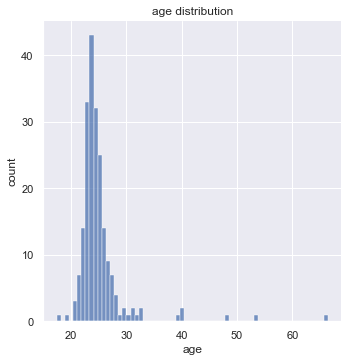

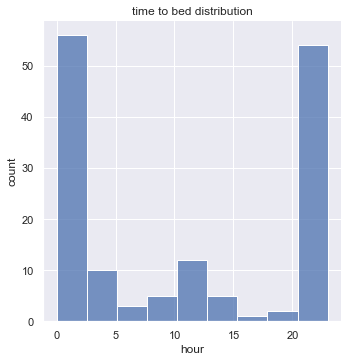

<Figure size 432x288 with 0 Axes>

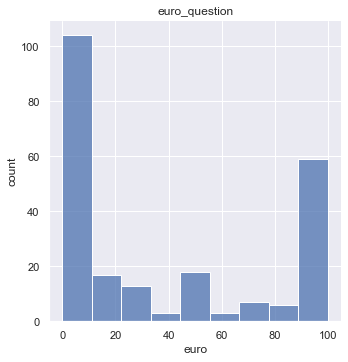

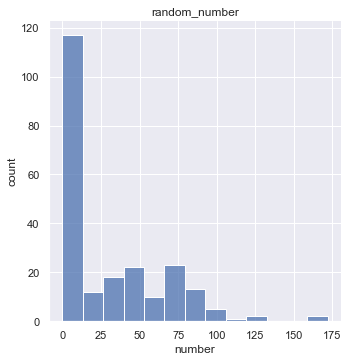

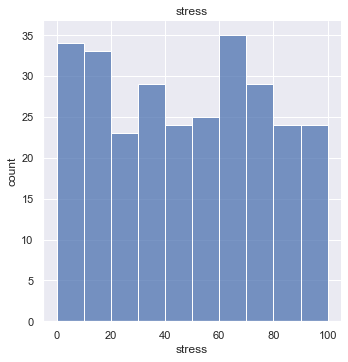

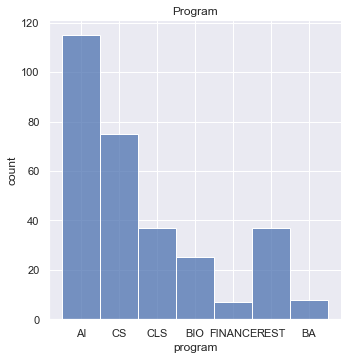

In [10]:
ax = sns.displot(data = odi_df, x='age')
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('count')

sns.displot(data = odi_df, x='time_to_bed')
plt.title('time to bed distribution')
plt.xlabel('hour')
plt.ylabel('count')
plt.figure(3)

sns.displot(data = odi_df, x='euro_question')
plt.title('euro_question')
plt.xlabel('euro')
plt.ylabel('count')

plt.figure(4)
sns.displot(data = odi_df, x='random_number')
plt.title('random_number')
plt.xlabel('number')
plt.ylabel('count')

plt.figure(5)
sns.displot(data = odi_df, x='stress')
plt.title('stress')
plt.xlabel('stress')
plt.ylabel('count')

plt.figure(6)
sns.displot(data = odi_df, x='program')
plt.title('Program')
plt.xlabel('program')
plt.ylabel('count')






<AxesSubplot:ylabel='Chocolate_influence'>

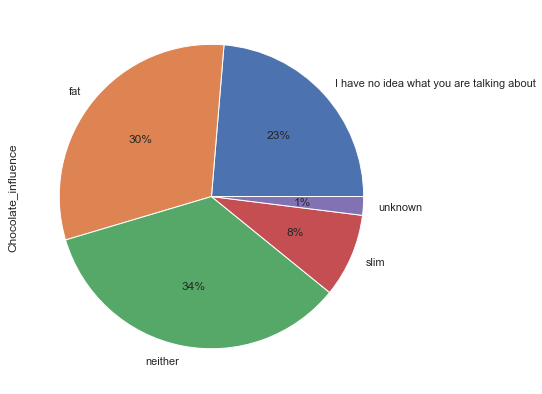

In [11]:



odi_df.groupby('Chocolate_influence')['Chocolate_influence'].count().plot.pie(autopct='%d%%',figsize=(7,7))


### Gender distribution

<AxesSubplot:ylabel='Gender'>

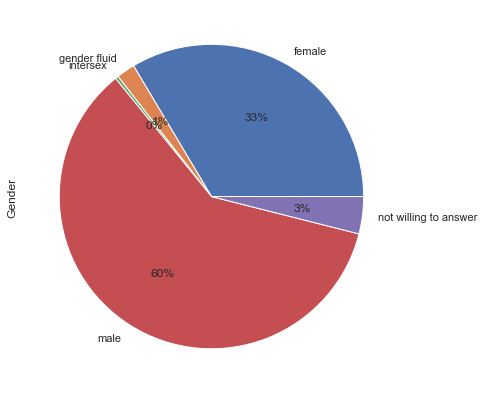

In [12]:
#display(odi_df.groupby('Gender')['Gender'].count())
odi_df.groupby('Gender')['Gender'].count().plot.pie(autopct='%d%%',figsize=(7,7))
#mask = (odi_df['Gender']!='male') & (odi_df['Gender']!='female')
#odi_df['Gender'].loc[mask]
#sns.displot(data=odi_df,x='Gender')


### correlations

In [13]:
odi_df.corr(method ='pearson')

,neighbors,stress,euro_question,random_number,time_to_bed,age
neighbors,1.000000,0.064969,0.097266,-0.019406,0.227899,0.032794
stress,0.064969,1.000000,0.066385,0.034167,-0.092959,-0.055480
euro_question,0.097266,0.066385,1.000000,0.018520,0.045666,0.163603
random_number,-0.019406,0.034167,0.018520,1.000000,0.008980,-0.065868
time_to_bed,0.227899,-0.092959,0.045666,0.008980,1.000000,-0.023124
age,0.032794,-0.055480,0.163603,-0.065868,-0.023124,1.000000


### correlations


<AxesSubplot:xlabel='program', ylabel='stress'>

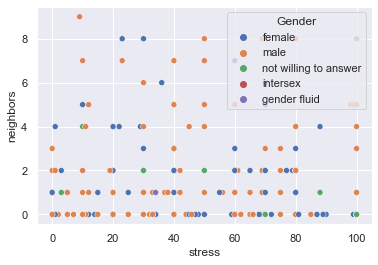

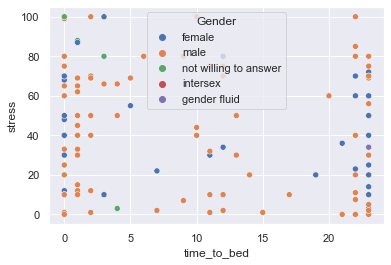

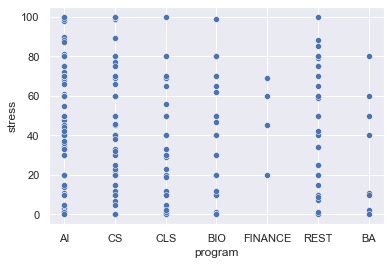

In [14]:
plt.figure(1)

sns.scatterplot(data=odi_df,x='stress', y='neighbors', hue='Gender')
plt.figure(2)

sns.scatterplot(data=odi_df,x='time_to_bed', y='stress', hue='Gender')
plt.figure(3)

sns.scatterplot(data=odi_df,x='program', y='stress')



### Pie chart of Gender put None as random number - no rule obeing 

Text(0.5, 1.0, 'gender distribution for correct data in random number')

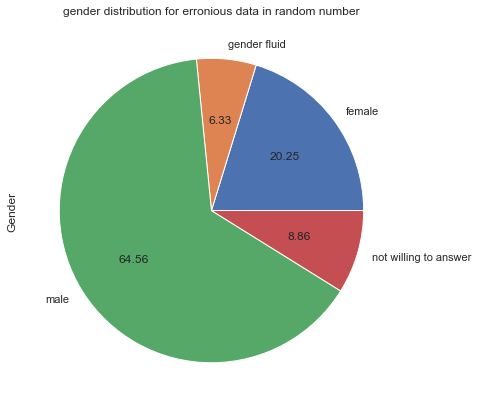

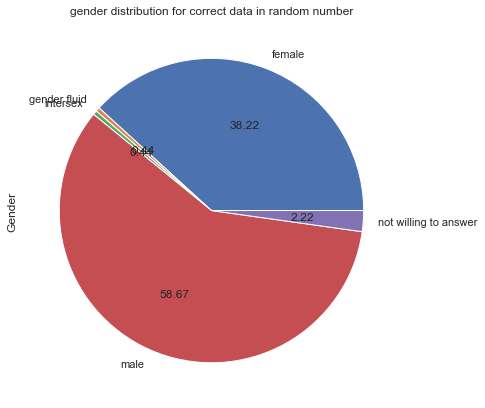

In [15]:
plt.figure(1)
odi_df[['Gender']].loc[odi_df['random_number'] .isna()].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for erronious data in random number')

plt.figure(2)
odi_df[['Gender']].loc[odi_df['random_number'] .isna()==False].groupby('Gender')['Gender'].count().plot.pie(autopct='%.2f',figsize=(7,7))
plt.title('gender distribution for correct data in random number')


### Good day distribution

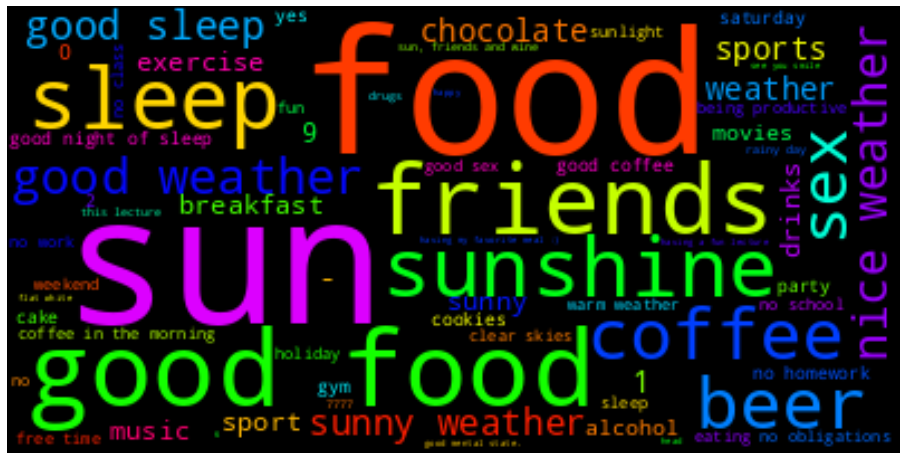

In [16]:
dictionary=Counter(list(odi_df['good_day_1'].map(str.lower))+list(odi_df['good_day_2'].map(str.lower)))
#dd = pd.DataFrame(dictionary, index=dictionary.keys)
#display(dd)
#sns.distplot( , x=index)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()



## Classifier

In [17]:
odi_df['MALE'] = odi_df['Gender']=='male'
odi_df['FEMALE'] = odi_df['Gender']=='female'
frequent_itemsets= apriori(odi_df[['ML','IR','DB','MALE','FEMALE']], min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(rules)


   antecedents     consequents  antecedent support  consequent support  \
0         (IR)            (ML)            0.269737            0.628289   
1         (ML)            (IR)            0.628289            0.269737   
2         (DB)            (ML)            0.539474            0.628289   
3         (ML)            (DB)            0.628289            0.539474   
4         (ML)          (MALE)            0.628289            0.601974   
..         ...             ...                 ...                 ...   
61  (ML, MALE)        (IR, DB)            0.384868            0.223684   
62        (IR)  (DB, ML, MALE)            0.269737            0.226974   
63        (DB)  (IR, ML, MALE)            0.539474            0.138158   
64        (ML)  (IR, DB, MALE)            0.628289            0.144737   
65      (MALE)    (IR, DB, ML)            0.601974            0.190789   

     support  confidence      lift  leverage  conviction  
0   0.223684    0.829268  1.319883  0.054211    2.17

In [18]:
mask = odi_df['stress'].isna()==False
X = odi_df[['ML','IR','DB','MALE','FEMALE','stress']].loc[mask]

Y = odi_df['program'].loc[mask]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
#X_train.shape, Y_train.shape, X_test.shape

In [32]:
neigh = KNeighborsClassifier(n_neighbors=9)

neigh.fit(X_train,Y_train)
neigh.score(X_test, Y_test)
kfold = KFold(n_splits=5)
scores = cross_val_score(neigh, X_train, Y_train, cv=kfold)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Y_pred = neigh.predict(X_test)#calculating accuracy
from sklearn.metrics import accuracy_score
print('Accuracy score is {}'.format(accuracy_score(Y_test, y_pred)))





0.36 accuracy with a standard deviation of 0.06
Accuracy score is 0.2976190476190476


49


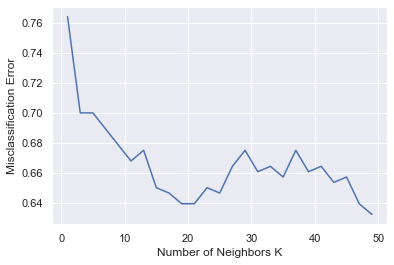

Accuracy score is 0.2976190476190476
0.35 accuracy with a standard deviation of 0.07
Accuracy score is 0.2976190476190476


In [34]:
cv_scores = []
neighbors = [x for x in range(1,50) if x % 2 != 0]
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean())#graphical view
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_k_index = MSE.index(min(MSE))
optimal_k = neighbors[optimal_k_index]
print(optimal_k)# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
Y_pred = neigh.predict(X_test)#calculating accuracy
from sklearn.metrics import accuracy_score
print('Accuracy score is {}'.format(accuracy_score(Y_test, y_pred)))


neigh = KNeighborsClassifier(n_neighbors=optimal_k_index)

neigh.fit(X_train,Y_train)
neigh.score(X_test, Y_test)
kfold = KFold(n_splits=5)
scores = cross_val_score(neigh, X_train, Y_train, cv=kfold)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Y_pred = neigh.predict(X_test)#calculating accuracy
print('Accuracy score is {}'.format(accuracy_score(Y_test, y_pred)))


In [26]:
tree = DecisionTreeClassifier()
tree.fit(X_train,Y_train)
scores_tree = cross_val_score(tree, X_train, Y_train, cv=kfold)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_tree.mean(), scores_tree.std()))
Y_pred = tree.predict(X_test)#calculating accuracy
print('Accuracy score is {}'.format(accuracy_score(Y_test, y_pred)))

0.27 accuracy with a standard deviation of 0.05
Acuracy score is 0.2976190476190476
